# **Spectral Index Evaluation of Land Use Compliance with the PBOT in La Ceja**
This project aims to analyze and quantify the urban expansion in La Ceja, a municipality located in Eastern Antioquia (Colombia), between the years 2018 and 2025. Using Sentinel-2 multispectral satellite imagery, we calculate spectral indices such as NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-up Index) and UI (Urban Index -Derived from NDVI and NDBI-) to detect changes in vegetation cover and built-up areas.

These spatial transformations are then compared with the urban growth zones defined in the Municipal Land Use Plan (PBOT) established by Agreement 001 of 2018. The overlay between remote sensing analysis and official planning boundaries allows us to assess whether recent urban development has occurred within legally designated areas or has exceeded regulated expansion zones.

This approach provides technical evidence to support sustainable territorial management, monitor compliance with planning regulations, and inform future decision-making by local authorities. The project also explores the effectiveness of remote sensing as a tool for land-use monitoring in rapidly growing intermediate municipalities.


## Libraries and necessary packs

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import glob
import os
from tqdm import tqdm
from IPython.display import display
import re

## Upload and stack verification

Code to verify the content of archives ".tif", it makes the band decomposition, index and description of each one

In [2]:
import rasterio
import os

stack_dir = "./carpeta_stacks" # Stacks directory
for filename in os.listdir(stack_dir):
    if filename.endswith(".tif"):
        file_path = os.path.join(stack_dir, filename)
        with rasterio.open(file_path) as src_file:
            print(f"File: {filename}")
            print("Number of bands:", src_file.count)
            print("Available index from bands:", src_file.indexes)
            desc = src_file.descriptions
            if desc is None:
                print("No descriptions available.")
            else:
                for idx, d in enumerate(desc, start=1):
                    print(f"Band {idx}: {d}")
            print("-" * 40) # Separator for clarity


File: 2018-08-07_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-01-04_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-07-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-08-27_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-01-09_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-02-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2023-08-26_stack

Esta secci√≥n recorre de forma autom√°tica todos los ‚Äústacks‚Äù multibanda y extrae los valores de √≠ndice en cada punto de muestreo, construyendo un √∫nico DataFrame (`df_all`) con toda la informaci√≥n. En concreto:

**Cargar GeoPackage**  
   Lee todas las capas de puntos almacenadas en `muestras_training.gpkg`. Cada capa se llama `pts_YYYY-MM-DD`, de modo que existe una capa distinta para cada fecha de muestreo.

**Listar r√°steres**  
   Utiliza `glob` para localizar todos los archivos GeoTIFF que sigan el patr√≥n `*_stack3.tif` dentro de la carpeta de ‚Äústacks‚Äù.

 **Extraer fecha**  
   Para cada archivo r√°ster, extrae la fecha (`YYYY-MM-DD`) del nombre de fichero mediante una expresi√≥n regular, de forma que luego podamos emparejarlo con la capa `pts_<fecha>` correspondiente.

**Muestrear √≠ndices**  
   Abre cada r√°ster con Rasterio y, tomando las coordenadas de cada punto de la capa `pts_<fecha>`, extrae los valores de las tres bandas:  
   - `NDVI`  
   - `NDBI`  
   - `UI`

**Construir registros**  
   Para cada fecha, crea un DataFrame parcial con las columnas:  
   - `raster_date`: fecha extra√≠da del nombre del archivo  
   - `point_date` : fecha original que figura en la capa de puntos  
   - `label`      : clase o etiqueta asociada a cada punto  
   - `x`, `y`     : coordenadas de cada punto  
   - `NDVI`, `NDBI`, `UI`: valores muestreados en esas coordenadas

**Concatenar todo**  
   Combina todos los DataFrames parciales en uno solo (`df_all`), reiniciando el √≠ndice para tener un √≠ndice continuo.

**Verificar resultados**  
   Muestra por consola:  
   - El n√∫mero total de muestras (`df_all.shape[0]`)  
   - La lista de columnas (`df_all.columns.tolist()`)  
   - Las primeras filas de `df_all.head(10)` para asegurarse de que los datos se han cargado y muestreado correctamente.  

In [3]:
# Ruta al geopackage y patr√≥n de archivos raster
gpkg_path      = './carpeta_stacks/muestras_training.gpkg'
stacks_pattern = './carpeta_stacks/*_stack3.tif'   # asegurarnos de que coincida con *_stack3.tif

# Listar capas disponibles en el GPKG, para verificar nombres
from fiona import listlayers
print("Capas en el GPKG:", listlayers(gpkg_path))

# Listar archivos raster
raster_files = sorted(glob.glob(stacks_pattern))
print(f"Found {len(raster_files)} raster stacks:")
for rf in raster_files:
    print(" ‚Ä¢", rf)

# Muestrear cada stack y construir registros
records = []
for rf in tqdm(raster_files, desc="Sampling stacks"):
    # Extraer solo la fecha con regex: busca 4 d√≠gitos-2 d√≠gitos-2 d√≠gitos
    filename = os.path.basename(rf)
    m = re.match(r'(\d{4}-\d{2}-\d{2})', filename)
    if not m:
        print(f"  ¬°No pude extraer fecha de '{filename}', salto este archivo.")
        continue
    date_str = m.group(1)
    
    pts_layer = f"pts_{date_str}"
    print(f"\n‚Üí Processing date {date_str}, layer '{pts_layer}'")
    
    # Leer la capa de puntos correspondiente
    try:
        gdf_pts = gpd.read_file(gpkg_path, layer=pts_layer)
    except Exception as e:
        print(f"  Error al leer la capa {pts_layer}: {e}")
        continue
    
    coords = [(pt.x, pt.y) for pt in gdf_pts.geometry]
    
    # Muestrear bandas NDVI, NDBI, UI
    with rasterio.open(rf) as src:
        samples = list(src.sample(coords))
    
    # Construir DataFrame de este d√≠a
    df = pd.DataFrame(samples, columns=['NDVI','NDBI','UI'])
    df['raster_date'] = date_str
    df['point_date']  = gdf_pts['date']
    df['label']       = gdf_pts['label']
    df['x']           = gdf_pts.geometry.x
    df['y']           = gdf_pts.geometry.y
    
    records.append(df)

# Concatenar todo en un solo DataFrame
if records:
    df_all = pd.concat(records, ignore_index=True)
    print("\nAll samples collected:", df_all.shape[0])
    print("Columns:", df_all.columns.tolist())
    print(df_all.head(10))
else:
    print("No se obtuvo ning√∫n registro.")

Capas en el GPKG: ['poly_2018-08-07', 'poly_2019-01-04', 'poly_2019-07-18', 'poly_2019-08-27', 'poly_2020-01-09', 'poly_2020-02-18', 'poly_2023-08-26', 'poly_2024-01-23', 'poly_2024-06-01', 'poly_2024-08-15', 'pts_2018-08-07', 'pts_2019-01-04', 'pts_2019-07-18', 'pts_2019-08-27', 'pts_2020-01-09', 'pts_2020-02-18', 'pts_2023-08-26', 'pts_2024-01-23', 'pts_2024-06-01', 'pts_2024-08-15']
Found 10 raster stacks:
 ‚Ä¢ ./carpeta_stacks\2018-08-07_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2019-01-04_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2019-07-18_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2019-08-27_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2020-01-09_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2020-02-18_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2023-08-26_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2024-01-23_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2024-06-01_stack3.tif
 ‚Ä¢ ./carpeta_stacks\2024-08-15_stack3.tif


Sampling stacks:   0%|          | 0/10 [00:00<?, ?it/s]


‚Üí Processing date 2018-08-07, layer 'pts_2018-08-07'


Sampling stacks:  20%|‚ñà‚ñà        | 2/10 [00:01<00:05,  1.53it/s]


‚Üí Processing date 2019-01-04, layer 'pts_2019-01-04'

‚Üí Processing date 2019-07-18, layer 'pts_2019-07-18'


Sampling stacks:  30%|‚ñà‚ñà‚ñà       | 3/10 [00:01<00:03,  2.09it/s]


‚Üí Processing date 2019-08-27, layer 'pts_2019-08-27'


Sampling stacks:  40%|‚ñà‚ñà‚ñà‚ñà      | 4/10 [00:02<00:02,  2.48it/s]


‚Üí Processing date 2020-01-09, layer 'pts_2020-01-09'


Sampling stacks:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 5/10 [00:02<00:01,  2.79it/s]


‚Üí Processing date 2020-02-18, layer 'pts_2020-02-18'


Sampling stacks:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 6/10 [00:02<00:01,  2.96it/s]


‚Üí Processing date 2023-08-26, layer 'pts_2023-08-26'


Sampling stacks:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 7/10 [00:02<00:01,  2.98it/s]


‚Üí Processing date 2024-01-23, layer 'pts_2024-01-23'


Sampling stacks:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 8/10 [00:03<00:00,  3.13it/s]


‚Üí Processing date 2024-06-01, layer 'pts_2024-06-01'


Sampling stacks:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 9/10 [00:03<00:00,  3.21it/s]


‚Üí Processing date 2024-08-15, layer 'pts_2024-08-15'


Sampling stacks: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:03<00:00,  2.60it/s]


All samples collected: 20000
Columns: ['NDVI', 'NDBI', 'UI', 'raster_date', 'point_date', 'label', 'x', 'y']
       NDVI      NDBI   UI raster_date  point_date  label          x         y
0  0.786443 -0.266387 -1.0  2018-08-07  2018-08-07      0 -75.457590  6.034681
1  0.699720 -0.191894 -1.0  2018-08-07  2018-08-07      0 -75.457657  6.035646
2  0.695204 -0.225916 -1.0  2018-08-07  2018-08-07      0 -75.454943  6.035268
3  0.676704 -0.233593 -1.0  2018-08-07  2018-08-07      0 -75.454789  6.035266
4  0.708695 -0.221719 -1.0  2018-08-07  2018-08-07      0 -75.456248  6.034848
5  0.652954 -0.159419 -1.0  2018-08-07  2018-08-07      0 -75.457122  6.035479
6  0.635360 -0.155753 -1.0  2018-08-07  2018-08-07      0 -75.455515  6.034363
7  0.763023 -0.231868 -1.0  2018-08-07  2018-08-07      0 -75.457403  6.034237
8  0.647756 -0.157061 -1.0  2018-08-07  2018-08-07      0 -75.454026  6.035202
9  0.705901 -0.191030 -1.0  2018-08-07  2018-08-07      0 -75.457640  6.035178


In [4]:
display(df_all.head(10))

NDVI      NDBI   UI raster_date  point_date  label          x         y
0  0.786443 -0.266387 -1.0  2018-08-07  2018-08-07      0 -75.457590  6.034681
1  0.699720 -0.191894 -1.0  2018-08-07  2018-08-07      0 -75.457657  6.035646
2  0.695204 -0.225916 -1.0  2018-08-07  2018-08-07      0 -75.454943  6.035268
3  0.676704 -0.233593 -1.0  2018-08-07  2018-08-07      0 -75.454789  6.035266
4  0.708695 -0.221719 -1.0  2018-08-07  2018-08-07      0 -75.456248  6.034848
5  0.652954 -0.159419 -1.0  2018-08-07  2018-08-07      0 -75.457122  6.035479
6  0.635360 -0.155753 -1.0  2018-08-07  2018-08-07      0 -75.455515  6.034363
7  0.763023 -0.231868 -1.0  2018-08-07  2018-08-07      0 -75.457403  6.034237
8  0.647756 -0.157061 -1.0  2018-08-07  2018-08-07      0 -75.454026  6.035202
9  0.705901 -0.191030 -1.0  2018-08-07  2018-08-07      0 -75.457640  6.035178

### Save DataFrame for out inspection

In [5]:
output_xlsx  = './carpeta_stacks/df_all_samples.xlsx' # Cambiar a la ruta deseada
df_all.to_excel(output_xlsx, index=False)
print(f"DataFrame exportado a Excel en: {output_xlsx}")

DataFrame exportado a Excel en: ./carpeta_stacks/df_all_samples.xlsx


Esta secci√≥n prepara las muestras crudas para el entrenamiento del modelo mediante:

**Alineaci√≥n temporal**  
   - Convertir `raster_date` y `point_date` a tipo `datetime`.  
   - Filtrar para conservar √∫nicamente los registros cuya fecha de r√°ster coincide exactamente con la fecha de muestreo del punto.  
   - Resultado: una muestra por punto en el d√≠a de adquisici√≥n correcto.

**Manejo de valores faltantes**  
   - Detectar cualquier `NaN` en las columnas `NDVI`, `NDBI` o `UI` (por ejemplo, debido a cobertura nubosa).  
   - Eliminar las muestras que contengan valores faltantes.

**Verificaci√≥n de distribuci√≥n**  
   - Generar diagramas de caja (boxplots) de cada √≠ndice (`NDVI`, `NDBI`, `UI`) agrupados por etiqueta de clase.  
   - Visualizar solapamientos o separaciones entre clases como comprobaci√≥n previa al entrenamiento.


In [6]:
# Convertir las fechas a tipo datetime
df_all['raster_date'] = pd.to_datetime(df_all['raster_date'], format='%Y-%m-%d')
df_all['point_date']  = pd.to_datetime(df_all['point_date'])

# Filtrar registros donde las fechas coinciden
df_matched = df_all[
    df_all['raster_date'] == df_all['point_date']
].copy()

# Mostrar resultados
print("Total de registros en df_all:   ", df_all.shape[0])
print("Registros con fecha coincidente:", df_matched.shape[0])
df_matched.head(10)

Total de registros en df_all:    20000
Registros con fecha coincidente: 20000


NDVI      NDBI   UI raster_date point_date  label          x         y
0  0.786443 -0.266387 -1.0  2018-08-07 2018-08-07      0 -75.457590  6.034681
1  0.699720 -0.191894 -1.0  2018-08-07 2018-08-07      0 -75.457657  6.035646
2  0.695204 -0.225916 -1.0  2018-08-07 2018-08-07      0 -75.454943  6.035268
3  0.676704 -0.233593 -1.0  2018-08-07 2018-08-07      0 -75.454789  6.035266
4  0.708695 -0.221719 -1.0  2018-08-07 2018-08-07      0 -75.456248  6.034848
5  0.652954 -0.159419 -1.0  2018-08-07 2018-08-07      0 -75.457122  6.035479
6  0.635360 -0.155753 -1.0  2018-08-07 2018-08-07      0 -75.455515  6.034363
7  0.763023 -0.231868 -1.0  2018-08-07 2018-08-07      0 -75.457403  6.034237
8  0.647756 -0.157061 -1.0  2018-08-07 2018-08-07      0 -75.454026  6.035202
9  0.705901 -0.191030 -1.0  2018-08-07 2018-08-07      0 -75.457640  6.035178

In [7]:
# Verificar valores faltantes
print("Valores faltantes por columna:\n", df_matched.isna().sum())
df_clean = df_matched.dropna(subset=['NDVI','NDBI','UI'])
print("Registros despu√©s de eliminar NaN en NDVI, NDBI o UI:", df_clean.shape[0])

Valores faltantes por columna:
 NDVI           0
NDBI           0
UI             0
raster_date    0
point_date     0
label          0
x              0
y              0
dtype: int64
Registros despu√©s de eliminar NaN en NDVI, NDBI o UI: 20000


<Figure size 640x480 with 0 Axes>

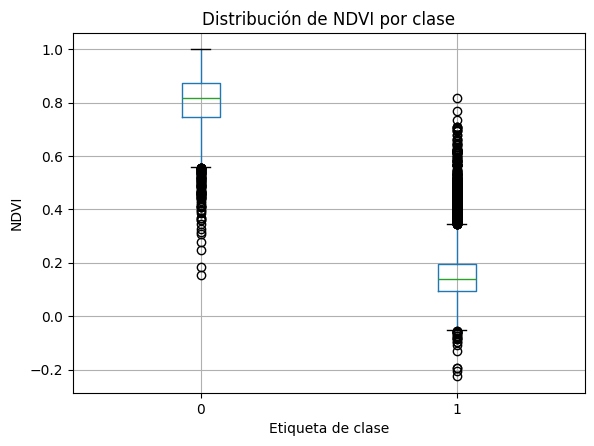

<Figure size 640x480 with 0 Axes>

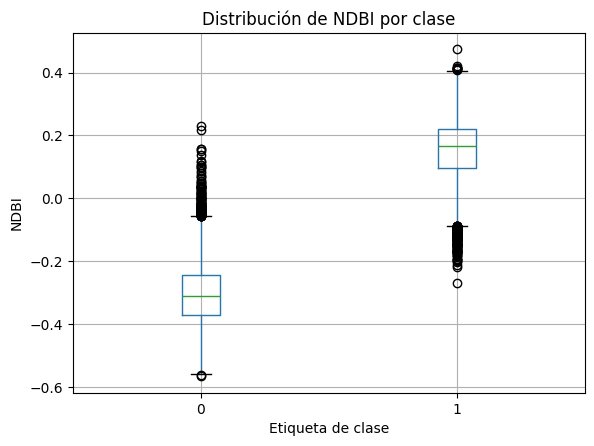

<Figure size 640x480 with 0 Axes>

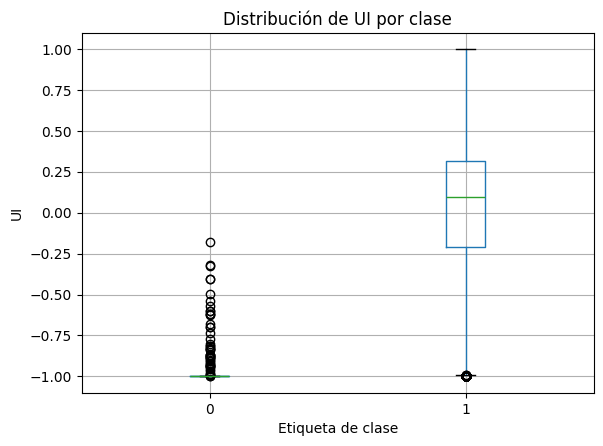

In [8]:
for idx in ['NDVI', 'NDBI', 'UI']:
    plt.figure()
    df_clean.boxplot(column=idx, by='label')
    plt.title(f'Distribuci√≥n de {idx} por clase')
    plt.suptitle('')
    plt.xlabel('Etiqueta de clase')
    plt.ylabel(idx)
    plt.show()

## An√°lisis de distribuciones por boxplot e √≠ndice

A continuaci√≥n se interpreta cada caja de distribuci√≥n en funci√≥n de la clase (0 vs. 1) y la l√≥gica espectral de los √≠ndices.

---

### 1. NDVI (√çndice de Vegetaci√≥n de Diferencia Normalizada)

- **Clase 0**  
  - **Mediana alta (~0,82)** y **IQR** estrecho (‚âà0,75‚Äì0,88): refleja vegetaci√≥n densa y saludable, que devuelve alta radiancia en el infrarrojo cercano y absorbe en rojo.  
  - **Rango superior** llega hasta ~1,0 (valores m√°ximos te√≥ricos de NDVI) y **outliers** inferiores (~0,15‚Äì0,40) pueden corresponder a puntos con vegetaci√≥n escasa o sombra.  
- **Clase 1**  
  - **Mediana baja (~0,15)** y IQR en torno a 0,10‚Äì0,20: caracteriza √°reas no vegetadas (suelo desnudo, √°reas urbanas), donde la firma de infrarrojo cercano es baja.  
  - Presencia de **outliers negativos** (hasta ~‚Äì0,20) sugiere superficies de agua o muy poca vegetaci√≥n.  

> **Conclusi√≥n**: la separaci√≥n neta entre medianas y rangos hace que NDVI sea muy discriminante entre vegetaci√≥n (clase 0) y no-vegetaci√≥n (clase 1).

---

### 2. NDBI (√çndice de Construcci√≥n Normalizada)

- **Clase 0**  
  - **Mediana negativa (~‚Äì0,30)** y IQR ‚âà‚Äì0,35 a ‚Äì0,25: coincide con vegetaci√≥n y suelo desnudo que devuelven m√°s reflectancia en SWIR que en NIR (valores negativos de NDBI).  
  - **Outliers** positivos aislados (~0,10‚Äì0,20) pueden deberse a suelos claros o materiales reflectantes temporales.  
- **Clase 1**  
  - **Mediana positiva (~0,18)** y IQR entre ~0,10 y 0,22: t√≠pico de √°reas urbanas o construidas, donde la reflectancia SWIR es menor frente a NIR.  
  - **Outliers altos** (~0,30‚Äì0,50) indican superficies muy reflectivas (techos, carreteras amplias).  

> **Conclusi√≥n**: NDBI invierte la l√≥gica del NDVI y discrimina bien construcciones (clase 1) con valores positivos, frente a vegetaci√≥n/suelos (clase 0) con valores negativos.

---

### 3. UI (Urban Index)

- **Clase 0**  
  - **Mediana cercana a ‚Äì1,0** y IQR muy estrecho alrededor de ese valor: representa zonas claramente no urbanas (vegetaci√≥n densa o agua), donde UI tiende a su l√≠mite negativo.  
  - **Outliers** por encima de ‚Äì0,8 pueden corresponder a peque√±as infraestructuras aisladas o caminos rurales.  
- **Clase 1**  
  - **Mediana cercana a 0,1** y IQR amplio (‚âà‚Äì0,2 a 0,4): refleja diversidad de superficies urbanas (techos, asfalto, hormig√≥n).  
  - **Rango superior** llega hasta ~1,0 (maximiza la respuesta urbana), y **outliers inferiores** (hasta ‚Äì1,0) podr√≠an ser puntos vac√≠os o ruido en la m√°scara urbana.  

> **Conclusi√≥n**: UI concentra los valores extremos para vegetaci√≥n/agua (cerca de ‚Äì1) y dispersa los valores urbanos entre ‚Äì0,2 y 1, lo cual encaja con su definici√≥n de realzar p√≠xeles construidos.

---

**Resumen general**  
Los tres √≠ndices muestran distribuciones que coinciden con sus principios espectrales:  
- **NDVI** alto en vegetaci√≥n, bajo en √°reas no vegetadas.  
- **NDBI** positivo en construcciones, negativo en vegetaci√≥n/suelo.  
- **UI** minimalista para ambiente natural y disperso para entorno urbano.  

Esta separaci√≥n clara respalda su uso conjunto para clasificar coberturas de suelo en entornos mixtos.  


### Divisi√≥n temporal Entrenamiento/Validaci√≥n

Este bloque segmenta el conjunto de datos seg√∫n la fecha de adquisici√≥n, garantizando que el modelo se entrene con las primeras 7 escenas y se valide con las 3 √∫ltimas, evitando as√≠ filtrado temporal:

**Fechas √∫nicas**  
   - Obtiene y ordena todas las fechas de escena de `df_clean`.  
**Definir partici√≥n**  
   - `train_dates`: primeras 7 fechas.  
   - `val_dates`  : √∫ltimas 3 fechas.  
**Subconjuntos**  
   - `df_train` y `df_val` con las muestras correspondientes a esas fechas.  
**Separar caracter√≠sticas y etiquetas**  
   - `X_train`, `y_train`, `X_val`, `y_val`.  
**Verificaci√≥n**  
   - Tama√±o de cada partici√≥n y balance de clases.  


In [9]:
# 1) Fechas √∫nicas ordenadas
unique_dates = sorted(df_clean['raster_date'].unique())

# 2) Definir fechas de entrenamiento (primeras 7) y validaci√≥n (√∫ltimas 3)
train_dates = unique_dates[:7]
val_dates   = unique_dates[7:]

# 3) Crear los DataFrames de train y validation
df_train = df_clean[df_clean['raster_date'].isin(train_dates)].copy()
df_val   = df_clean[df_clean['raster_date'].isin(val_dates)].copy()

# 4) Extraer caracter√≠sticas y etiquetas
features = ['NDVI', 'NDBI', 'UI']
X_train, y_train = df_train[features], df_train['label']
X_val,   y_val   = df_val[features],   df_val['label']

# 5) Ver tama√±os y balance de clases
print(f"Train set: {X_train.shape[0]} muestras de fechas {train_dates}")
print(f"Val   set: {X_val.shape[0]} muestras de fechas {val_dates}\n")

print("Conteo de clases en Train:\n", y_train.value_counts())
print("\nConteo de clases en Val:\n",   y_val.value_counts())


Train set: 14000 muestras de fechas [Timestamp('2018-08-07 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-07-18 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-02-18 00:00:00'), Timestamp('2023-08-26 00:00:00')]
Val   set: 6000 muestras de fechas [Timestamp('2024-01-23 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-08-15 00:00:00')]

Conteo de clases en Train:
 label
0    7000
1    7000
Name: count, dtype: int64

Conteo de clases en Val:
 label
0    3000
1    3000
Name: count, dtype: int64


### Model Training and Evaluation

Entrenamos un clasificador **Random Forest** sobre los datos de entrenamiento (primeras 7 fechas) y evaluamos su rendimiento en el conjunto de validaci√≥n (√∫ltimas 3 fechas).

**¬øPor qu√© usar Random Forest?**  
- **Robustez**: combina m√∫ltiples √°rboles de decisi√≥n para reducir el sobreajuste y aguantar bien ruido y outliers.  
- **No linealidad**: captura relaciones complejas entre `NDVI`, `NDBI` y `UI` sin necesidad de transformar las variables.  
- **Poco preprocesamiento**: no requiere escalado ni normalizaci√≥n de las caracter√≠sticas.  
- **Importancia de variables**: facilita saber qu√© √≠ndices aportan m√°s a la clasificaci√≥n (feature importance).  
- **Paralelizaci√≥n**: puede entrenar muchos √°rboles en paralelo (usando `n_jobs=-1`) para aprovechar todos los n√∫cleos de CPU.

In [10]:
# Libraries for model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [11]:
# 1) Initialize the Random Forest classifier
#    - 100 √°rboles, profundidad ilimitada (se dejan crecer completamente)
#    - random_state para reproducibilidad
#    - n_jobs=-1 para usar todos los n√∫cleos de CPU
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2) Fit the model on the training data
#    X_train: features ['NDVI','NDBI','UI']
#    y_train: labels (0 o 1)
clf.fit(X_train, y_train)
print("Model training complete.")

# 3) Make predictions on the validation set
y_pred = clf.predict(X_val)
print("Predictions on validation set generated.")

# 4) Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.3f}")

# 5) Display confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 6) Show full classification report (precision, recall, f1-score)
report = classification_report(y_val, y_pred)
print("\nClassification Report:")
print(report)

Model training complete.
Predictions on validation set generated.
Validation Accuracy: 0.980

Confusion Matrix:
[[2905   95]
 [  26 2974]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3000
           1       0.97      0.99      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



##  Resumen de resultados y definici√≥n de m√©tricas

A continuaci√≥n explicamos cada uno de los n√∫meros obtenidos y el significado de las m√©tricas:

---

### 1. Accuracy (Exactitud global)
- **Valor**: `0.980`  
- **Definici√≥n**: proporci√≥n de predicciones correctas sobre el total de muestras.  
- **True positives**: Son los casos en que el modelo predice positiva una instancia y realmente pertenece a la clase positiva.
- **True negatives**: Son los casos en que el modelo predice negativa una instancia y realmente pertenece a la clase negativa.
- **C√°lculo**:  
  $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total}}
    = \frac{2974 + 2905}{6000} = 0.98
  $$ 
  donde  
  - TP (True Positives) = 2974  
  - TN (True Negatives) = 2905  
  - Total = 6000 muestras  

---

### 2. Matriz de confusi√≥n

|                 | Predicci√≥n = 0 | Predicci√≥n = 1 |
|:---------------:|:--------------:|:--------------:|
| **Real = 0**    | TN = 2905      | FP = 95        |
| **Real = 1**    | FN = 26        | TP = 2974      |

- **TN (True Negative)**: puntos de clase 0 correctamente clasificados (2905).  
- **FP (False Positive)**: puntos de clase 0 mal clasificados como clase 1 (95). Son los casos en que el modelo predice positiva una instancia, pero en realidad pertenece a la clase 
- **FN (False Negative)**: puntos de clase 1 mal clasificados como clase 0 (26). Son los casos en que el modelo predice negativa una instancia, pero en realidad pertenece a la clase positiva.
- **TP (True Positive)**: puntos de clase 1 correctamente clasificados (2974).  

---

### 3. M√©tricas por clase

Para cada etiqueta (0 = vegetaci√≥n, 1 = urbano) se calculan:

| Clase | Precision | Recall  | F1-score | Support |
|:-----:|:---------:|:-------:|:--------:|:-------:|
|   0   |   0.99    |  0.97   |   0.98   |  3000   |
|   1   |   0.97    |  0.99   |   0.98   |  3000   |

- **Precision**  
  $$
    \text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}
  $$  
  Porcentaje de predicciones ‚Äúpositivas‚Äù para la clase _c_ que fueron correctas.  
  - Clase 0:  
    $ \frac{2905}{2905 + 26} \approx 0.99 $  
  - Clase 1:  
    $ \frac{2974}{2974 + 95} \approx 0.97 $

- **Recall** (o Sensibilidad)  
  $$
    \text{Recall}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
  $$ 
  Proporci√≥n de instancias reales de la clase _c_ que el modelo identific√≥ correctamente.  
  - Clase 0:  
    $ \frac{2905}{2905 + 95} \approx 0.97 $ 
  - Clase 1:  
    $ \frac{2974}{2974 + 26} \approx 0.99 $

- **F1-score**  
  $$
    \text{F1}_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
  $$  
  Media arm√≥nica de Precision y Recall, penaliza tanto falsos positivos como falsos negativos. Aqu√≠ est√° en **0.98** para ambas clases, indicando un buen equilibrio.

- **Support**  
  N√∫mero de muestras reales de cada clase en el conjunto de validaci√≥n (3000 para cada una).

---

### 4. Promedios agregados

| M√©trica      | Macro avg | Weighted avg |
|:------------:|:---------:|:------------:|
| **Precision**|   0.98    |     0.98     |
| **Recall**   |   0.98    |     0.98     |
| **F1-score** |   0.98    |     0.98     |

- **Macro avg**: promedio simple de la m√©trica entre clases (trata ambas por igual).  
- **Weighted avg**: promedio ponderado seg√∫n el n√∫mero de muestras por clase (aqu√≠ es id√©ntico porque ambas clases tienen el mismo support).

---

## Interpretaci√≥n general

1. **Alta exactitud** (98%): el modelo acierta casi todas las veces.  
2. **Balance por clase**: tanto Precision como Recall y F1 est√°n alrededor de 0.98‚Äì0.99 en ambas clases, lo que indica que no hay sesgo hacia vegetaci√≥n o urbano.  
3. **Pocos errores cr√≠ticos**:  
   - Solo 121 errores totales sobre 6000 muestras (95 FP + 26 FN).  
   - El modelo identifica muy bien puntos urbanos (Recall_1=0.99) y vegetaci√≥n (Recall_0=0.97).  

Estos resultados confirman que el Random Forest, entrenado con NDVI, NDBI y UI, discrimina de forma eficaz entre vegetaci√≥n y entorno urbano en fechas no vistas durante el entrenamiento.  


### Importancia de las caracter√≠sticas (Feature Importances)

Este paso calcula y visualiza la contribuci√≥n de cada √≠ndice (`NDVI`, `NDBI`, `UI`) al rendimiento del Random Forest:

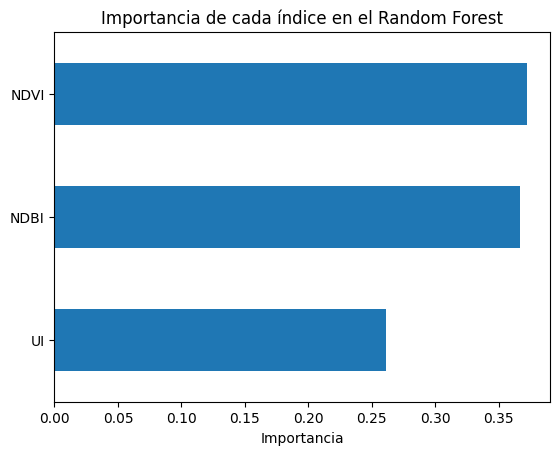

In [12]:
# 1) Extraer importancias del modelo
importances = clf.feature_importances_ # NDVI, NDBI, UI

# 2) Crear un Series para ordenarlas f√°cilmente
feat_imp = pd.Series(importances, index=['NDVI', 'NDBI', 'UI']).sort_values()

# 3) Dibujar un gr√°fico horizontal de barras
plt.figure()
feat_imp.plot.barh()
plt.xlabel("Importancia")
plt.title("Importancia de cada √≠ndice en el Random Forest")
plt.show()

## An√°lisis de importancias de los √≠ndices

El gr√°fico muestra la contribuci√≥n relativa de cada √≠ndice (`NDVI`, `NDBI`, `UI`) al rendimiento del modelo Random Forest:

| √çndice | Importancia aproximada |
|:------:|:----------------------:|
| **NDVI** | 0.38 |
| **NDBI** | 0.37 |
| **UI**   | 0.25 |

### Interpretaci√≥n

1. **NDVI (‚âà 38 %)**  
   - Es el √≠ndice m√°s determinante para distinguir vegetaci√≥n vs. no vegetaci√≥n.  
   - Su alta importancia se alinea con la clara separaci√≥n observada en los boxplots: valores elevados en vegetaci√≥n y bajos en √°reas urbanas.

2. **NDBI (‚âà 37 %)**  
   - Muy cercano a NDVI en importancia, lo que indica que el contraste sociedad‚Äìsuelo/vegetaci√≥n tambi√©n aporta casi tanto como el √≠ndice de vegetaci√≥n.  
   - Su rol complementa al NDVI especialmente en zonas mixtas o con suelos expuestos donde NDVI pierde algo de discriminaci√≥n.

3. **UI (‚âà 25 %)**  
   - Contribuye menos que NDVI y NDBI, pero sigue siendo relevante (25 % del ‚Äúpeso‚Äù total).  
   - Probablemente capta matices urban√≠sticos (asfalto, hormig√≥n) que no quedan del todo reflejados por NDVI/NDBI.

### Conclusiones y siguientes pasos

- La fuerte aportaci√≥n de **NDVI** y **NDBI** confirma que los √≠ndices espectrales cl√°sicos son eficaces para separar vegetaci√≥n de zonas construidas.  
- El **UI**, aunque menos determinante, a√±ade informaci√≥n exclusiva del entorno urbano; descartarlo totalmente podr√≠a reducir robustez en casos complejos.  
- **Posibles acciones**:
  - Mantener los tres √≠ndices para maximizar generalizaci√≥n.
  - Explorar nuevos √≠ndices o transformaciones de UI que potencien su aporte.

## B√∫squeda de hiperpar√°metros con GridSearchCV

 **b√∫squeda exhaustiva** (‚Äúgrid search‚Äù) sobre distintas combinaciones de par√°metros del Random Forest, usando **validaci√≥n cruzada** para evaluar cada configuraci√≥n. Esto ayuda a optimizar el rendimiento del modelo y evitar configuraciones sub√≥ptimas.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':      [100, 200, 300],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Ejecutar b√∫squeda
grid.fit(X_train, y_train)

# Mostrar resultados
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Reemplazar clf por el mejor estimador
clf = grid.best_estimator_


Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.9939284693185071


In [14]:
y_pred = clf.predict(X_val)
print("Accuracy (con mejores params):", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy (con mejores params): 0.9798333333333333
[[2905   95]
 [  26 2974]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3000
           1       0.97      0.99      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



## Mejores par√°metros encontrados

Tras ejecutar la b√∫squeda con `GridSearchCV`, los hiperpar√°metros √≥ptimos son:

- **n_estimators**: `100`  
  _(igual al valor por defecto del modelo anterior)_

- **min_samples_split**: `2`  
  _(igual al valor por defecto)_

- **max_depth**: `10`  
  _(antes era `None`, es decir, √°rboles sin l√≠mite de profundidad)_

---

### Impacto en la m√©trica

- **Accuracy en validaci√≥n**: `0.9798`  
- **Matriz de confusi√≥n** y **classification report**: id√©nticos (hasta redondeos) a los obtenidos con los valores por defecto.

**Conclusi√≥n**:  
El GridSearchCV confirma que `n_estimators=100` y `min_samples_split=2` ya estaban bien calibrados. Por lo tanto, limitar la profundidad a 10 no altera la performance en validaci√≥n, lo que sugiere que los √°rboles ilimitados tampoco estaban sobreajustando de forma significativa. En este caso, los valores por defecto resultan pr√°cticamente √≥ptimos para este dataset de √≠ndices espectrales.  

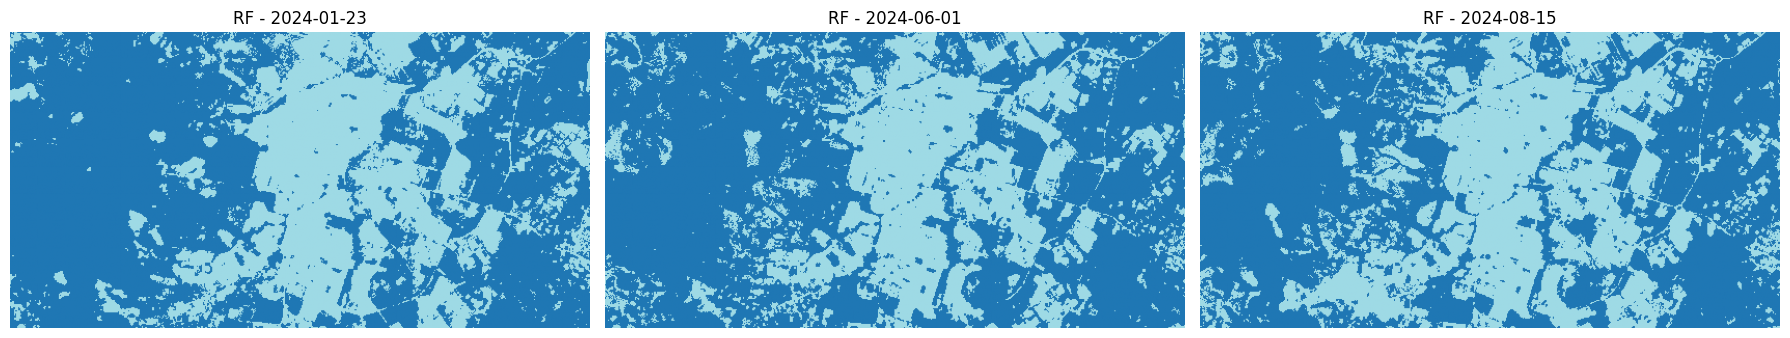

In [15]:
# Fechas y configuraci√≥n
fechas   = ['2024-01-23', '2024-06-01', '2024-08-15']
col_names = ['NDVI', 'NDBI', 'UI']
cmap      = plt.cm.tab20
cmap.set_under('none')

# Crear figura con 3 subplots en una fila
fig, axes = plt.subplots(1, len(fechas), figsize=(18, 6))

for ax, fecha in zip(axes, fechas):
    path_stack = f'./carpeta_stacks/{fecha}_stack3.tif'
    
    with rasterio.open(path_stack) as src:
        # Leer √≠ndices como float32
        img = src.read([1, 2, 3]).astype(np.float32)  # shape = (3, H, W)
        H, W = img.shape[1], img.shape[2]
        
        # Reemplazo de nodata (si existe)
        nodata = src.nodata
        if nodata is not None:
            img[img == nodata] = 0.0
        
        # Aplanar y limpiar valores inv√°lidos
        pix = img.reshape(3, -1).T                    # (H*W, 3)
        pix = np.nan_to_num(pix, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Reconstruir DataFrame para el pipeline
        pix_df = pd.DataFrame(pix, columns=col_names)
        
        # Predecir con Random Forest y reconstruir mapa
        pred      = clf.predict(pix_df)           # (H*W,)
        pred_map  = pred.reshape(H, W)
    
    # Mostrar en el subplot correspondiente
    ax.imshow(pred_map, cmap=cmap, vmin=0)
    ax.set_title(f'RF - {fecha}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Clasificaci√≥n con SVM (Support Vector Machine)

Para comparar con el Random Forest, entrenaremos un **SVM** sobre las mismas caracter√≠sticas (`NDVI`, `NDBI`, `UI`) y evaluaremos su desempe√±o en el conjunto de validaci√≥n.

**¬øPor qu√© SVM?**  
- Encuentra el **hiperplano de m√°xima separaci√≥n** entre clases, lo que puede mejorar la generalizaci√≥n en datasets con pocas variables.  
- Funciona bien en problemas de clasificaci√≥n binaria con un n√∫mero moderado de caracter√≠sticas.  
- Permite regularizar el modelo a trav√©s del par√°metro `C` para controlar el **trade-off** entre margen ancho y errores de clasificaci√≥n.  
- Podemos probar distintos **kernels** (lineal, RBF, polin√≥mico) para capturar relaciones no lineales.


In [16]:
# Librerias para SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
# Construir un pipeline con escalador y SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),      # Escala las caracter√≠sticas (importante para SVM)
    ('svm', SVC(kernel='rbf', C=1.0, random_state=42))  # Kernel RBF por defecto
])

# Entrenar el modelo en los datos de entrenamiento
pipe_svm.fit(X_train, y_train)
print("Entrenamiento SVM completo.")

# Predecir sobre el conjunto de validaci√≥n
y_pred_svm = pipe_svm.predict(X_val)
print("Predicciones SVM en validaci√≥n generadas.")

# Calcular accuracy
acc_svm = accuracy_score(y_val, y_pred_svm)
print(f"Accuracy (SVM): {acc_svm:.3f}")

# Mostrar matriz de confusi√≥n
cm_svm = confusion_matrix(y_val, y_pred_svm)
print("\nMatriz de confusi√≥n (SVM):")
print(cm_svm)

# Mostrar reporte completo de clasificaci√≥n
report_svm = classification_report(y_val, y_pred_svm)
print("\nClassification Report (SVM):")
print(report_svm)

Entrenamiento SVM completo.
Predicciones SVM en validaci√≥n generadas.
Accuracy (SVM): 0.984

Matriz de confusi√≥n (SVM):
[[2911   89]
 [   8 2992]]

Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3000
           1       0.97      1.00      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



c:\Users\pipix\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6000/6000 [01:15<00:00, 79.44it/s]


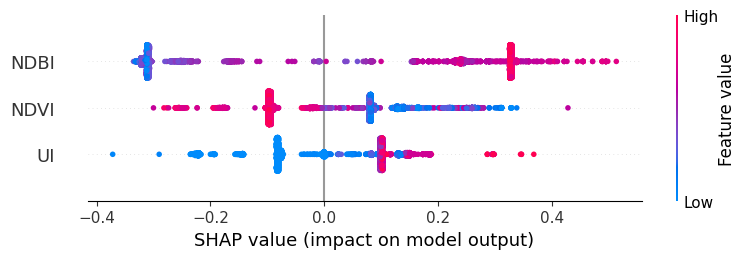

In [18]:
import shap

explainer = shap.KernelExplainer(clf.predict, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_val)

# Resumen de importantes
shap.summary_plot(shap_values, X_val, feature_names=['NDVI','NDBI','UI'])


## Comparaci√≥n de Random Forest vs SVM

Para comparar claramente ambos modelos, hay que hacerlo con los datos de ambos, por lo tanto, se realiza un c√≥digo que:

1. Reutiliza los modelos ya entrenados (`clf` para Random Forest y `pipe_svm` para SVM).  
2. Calcula las m√©tricas clave sobre el conjunto de validaci√≥n.  
3. Agrupa todo en un DataFrame para comparar de forma clara.  
4. Indica autom√°ticamente cu√°l modelo obtuvo mejor **accuracy**.

In [19]:
# Definir los modelos a comparar
models = {
    'Random Forest': clf,
    'SVM':           pipe_svm
}

# Recopilar m√©tricas
results = []
for name, model in models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    results.append({
        'Modelo': name,
        'Accuracy': acc,
        'Precision (0)': report['0']['precision'],
        'Recall (0)':    report['0']['recall'],
        'F1 (0)':        report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)':    report['1']['recall'],
        'F1 (1)':        report['1']['f1-score'],
        'Macro F1':      report['macro avg']['f1-score'],
        'Weighted F1':   report['weighted avg']['f1-score']
    })

# Convertir a DataFrame y ordenar por accuracy
df_comparison = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
display(df_comparison)

# Indicar modelo ganador
best_model = df_comparison.iloc[0]
print(f"\nMejor modelo: {best_model['Modelo']} con Accuracy = {best_model['Accuracy']:.3f}")

Modelo  Accuracy  Precision (0)  Recall (0)    F1 (0)  \
1            SVM  0.983833       0.997259    0.970333  0.983612   
0  Random Forest  0.979833       0.991129    0.968333  0.979599   

   Precision (1)  Recall (1)    F1 (1)  Macro F1  Weighted F1  
1       0.971113    0.997333  0.984049  0.983830     0.983830  
0       0.969045    0.991333  0.980063  0.979831     0.979831


Mejor modelo: SVM con Accuracy = 0.984


## Resumen de resultados y definici√≥n de m√©tricas (SVM)

A continuaci√≥n presentamos los n√∫meros obtenidos con el modelo SVM y explicamos el significado de cada m√©trica:

---

### 1. Accuracy (Exactitud global)
- **Valor**: `0.984`  
- **Definici√≥n**: proporci√≥n de predicciones correctas sobre el total de muestras.  
- **True positives (TP)**: casos en que el modelo predice positiva una instancia y realmente pertenece a la clase positiva.  
- **True negatives (TN)**: casos en que el modelo predice negativa una instancia y realmente pertenece a la clase negativa.  
- **C√°lculo**:  
  $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total}}
    = \frac{2992 + 2911}{6000} \approx 0.984
  $$  
  donde  
  - TP = 2992  
  - TN = 2911  
  - Total = 6000 muestras  

---

### 2. Matriz de confusi√≥n

|                 | Predicci√≥n = 0 | Predicci√≥n = 1 |
|:---------------:|:--------------:|:--------------:|
| **Real = 0**    | TN = 2911      | FP = 89        |
| **Real = 1**    | FN = 8         | TP = 2992      |

- **TN (True Negative)**: vegetaci√≥n correctamente clasificada (2911).  
- **FP (False Positive)**: vegetaci√≥n clasificada como urbano (89).  
- **FN (False Negative)**: urbano clasificado como vegetaci√≥n (8).  
- **TP (True Positive)**: urbano correctamente clasificado (2992).  

---

### 3. M√©tricas por clase

Para cada etiqueta (0 = vegetaci√≥n, 1 = urbano) se calculan:

| Clase | Precision | Recall  | F1-score | Support |
|:-----:|:---------:|:-------:|:--------:|:-------:|
|   0   |   0.9973  |  0.9703 |   0.9836 |  3000   |
|   1   |   0.9711  |  0.9973 |   0.9840 |  3000   |

- **Precision**  
  $$
    \text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}
  $$  
  - Clase 0: $\displaystyle \frac{2911}{2911 + 8} \approx 0.9973$  
  - Clase 1: $\displaystyle \frac{2992}{2992 + 89} \approx 0.9711$  

- **Recall** (Sensibilidad)  
  $$
    \text{Recall}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
  $$  
  - Clase 0: $\displaystyle \frac{2911}{2911 + 89} \approx 0.9703$  
  - Clase 1: $\displaystyle \frac{2992}{2992 + 8} \approx 0.9973$  

- **F1-score**  
  $$
    \text{F1}_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
  $$  
  Ambas clases alcanzan aproximadamente **0.98**, indicando un s√≥lido equilibrio.  

- **Support**  
  N√∫mero de muestras reales de cada clase en validaci√≥n (3000 cada una).

---

### 4. Promedios agregados

| M√©trica      | Macro avg | Weighted avg |
|:------------:|:---------:|:------------:|
| **Precision**|   0.9842  |    0.9842    |
| **Recall**   |   0.9838  |    0.9838    |
| **F1-score** |   0.9838  |    0.9838    |

- **Macro avg**: promedio simple entre clases.  
- **Weighted avg**: promedio ponderado por n√∫mero de muestras (id√©ntico aqu√≠ dado el mismo support).

---

## Interpretaci√≥n general

1. **Muy alta exactitud** (98.4 %): el SVM acierta casi todas las veces.  
2. **Equilibrio de clases**: Precision, Recall y F1 rondan 0.98‚Äì0.99 en ambas clases, sin sesgo hacia vegetaci√≥n o urbano.  
3. **M√≠nimos errores**: solo 97 errores en total (89 FP + 8 FN).  

Estos resultados confirman que el SVM, con kernel RBF y datos normalizados de `NDVI`, `NDBI` y `UI`, discrimina eficazmente entre vegetaci√≥n y √°reas urbanas en fechas no vistas durante el entrenamiento.  


Hasta ahora hemos **Entrenado y comparado** dos modelos (Random Forest vs SVM) y, adem√°s, **Elegido** el *SVM como mejor clasificador** sobre el set de validaci√≥n.

Lo siguiente ser√°:

* **Visualizar** de forma gr√°fica los resultados de validaci√≥n  
* **Generar mapas de clasificaci√≥n espacial** para una o dos escenas de validaci√≥n  
* **Extraer la serie temporal** de huella urbana  
* **Ajustar un modelo de tendencia** para predecir la expansi√≥n urbana hacia 2030  

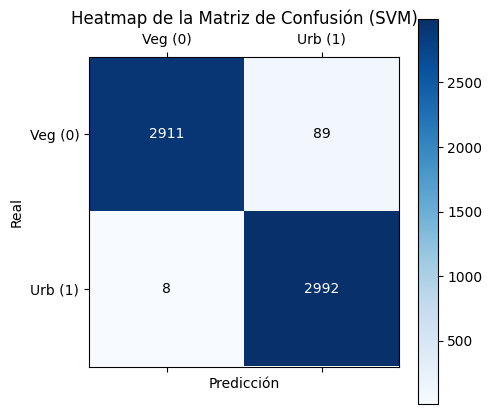

In [20]:
# Matriz de confusi√≥n - Igual que en el bloque anterior, pero en plot para visualizar mejor y poner en informe
cm = confusion_matrix(y_val, pipe_svm.predict(X_val))

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='white' if val>cm.max()/2 else 'black')

ax.set_xlabel('Predicci√≥n')
ax.set_ylabel('Real')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Veg (0)','Urb (1)'])
ax.set_yticklabels(['Veg (0)','Urb (1)'])
fig.colorbar(cax)
plt.title('Heatmap de la Matriz de Confusi√≥n (SVM)')
plt.show()

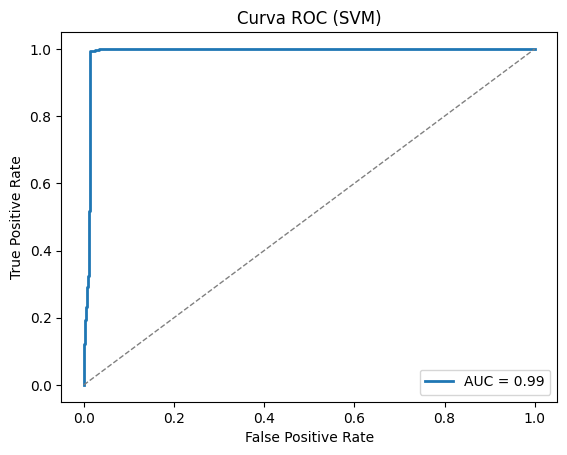

In [21]:
from sklearn.metrics import roc_curve, auc

# Obtener puntuaciones de decisi√≥n (distancia al hiperplano)
y_scores = pipe_svm.decision_function(X_val)

fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (SVM)')
plt.legend(loc='lower right')
plt.show()

## üìà Interpretaci√≥n de la Curva ROC (SVM)

La **Curva ROC** (Receiver Operating Characteristic) es una herramienta para evaluar la capacidad discriminativa de un clasificador binario, aqu√≠ tu SVM.

---

### Ejes de la gr√°fica

- **Eje X** (False Positive Rate, FPR)  
  $
    \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
  $  
  Es la proporci√≥n de negativos reales (clase 0) que el modelo clasifica incorrectamente como positivos (clase 1). Va de 0 (ning√∫n falso positivo) a 1 (todos los negativos err√≥neamente positivos).

- **Eje Y** (True Positive Rate, TPR o Recall)  
  $
    \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  $  
  Es la proporci√≥n de positivos reales (clase 1) que el modelo identifica correctamente. Va de 0 (ning√∫n verdadero positivo) a 1 (todos los positivos correctamente identificados).

---

### C√≥mo leer la curva

- Cada punto de la curva corresponde a un **umbral** distinto en la funci√≥n de decisi√≥n del SVM.  
- Cuando el umbral es muy alto, el modelo es muy conservador (pocos positivos predichos ‚Üí baja TPR, baja FPR).  
- Cuando el umbral es muy bajo, predice muchos positivos (alta TPR, alta FPR).  
- El **ideal** es tener TPR cerca de 1 (casi todos los positivos detectados) y FPR cerca de 0 (pocos falsos positivos).

---

### L√≠nea diagonal punteada

- Representa una **clase aleatoria** (un clasificador que adivina sin informaci√≥n): TPR = FPR para todos los umbrales, AUC = 0.5.  
- Cualquier curva por encima de esa l√≠nea indica mejor poder discriminativo que el azar.

---

### AUC (Area Under Curve)

- **Valor**: `0.99`  
- **Definici√≥n**: √°rea bajo la curva ROC, resumen √∫nico de la capacidad de discriminaci√≥n.  
  - AUC = 1.0: clasificador perfecto (separa completamente ambas clases).  
  - AUC = 0.5: rendimiento equivalente al azar.  
- **Tu resultado** (`0.99`): indica que el SVM casi siempre distingue correctamente entre vegetaci√≥n y urbano, independientemente del umbral elegido.

---

### Conclusi√≥n

La curva ROC con AUC ‚âà 0.99 confirma que:

- El SVM tiene **excelente capacidad** para diferenciar entre ambas clases.  
- Funciona bien a trav√©s de todo el rango de umbrales, no depender√° de un umbral muy espec√≠fico para rendir correctamente.  
- Es un indicador robusto de que tu modelo es fiable y generaliza bien.



## Visualizaci√≥n de los 3 stacks de validaci√≥n

Para cada fecha de validaci√≥n se genera la predicci√≥n pixel a pixel y se crea una figura, para poder tener un resultado visual de lo que sucedi√≥ en la predicci√≥n y clasificaci√≥n del modelo.

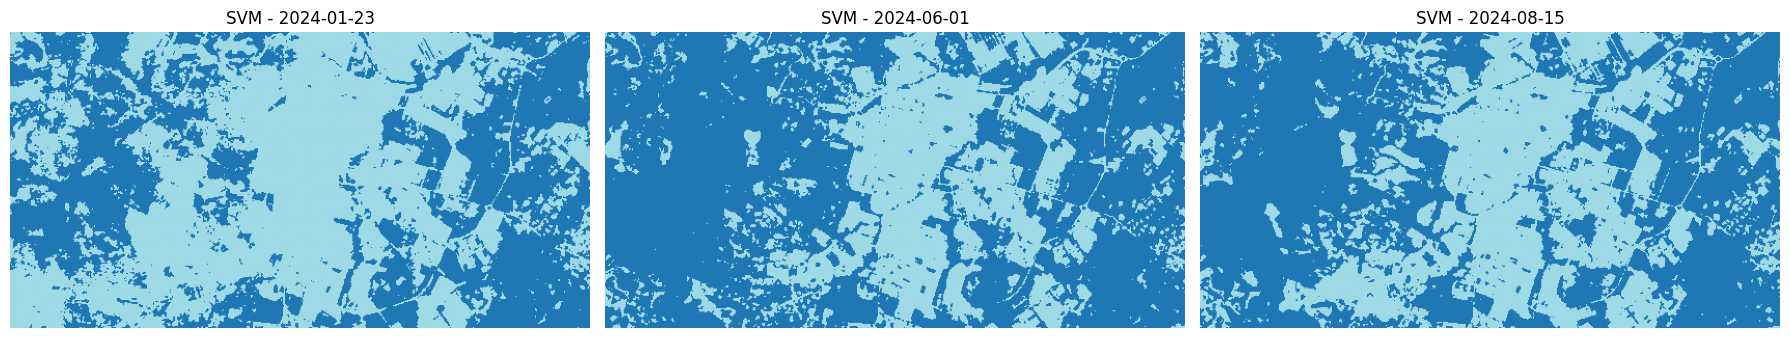

In [22]:
# Fechas y configuraci√≥n
fechas = ['2024-01-23', '2024-06-01', '2024-08-15']
col_names = ['NDVI', 'NDBI', 'UI']
cmap = plt.cm.tab20
cmap.set_under('none')

# Crear figura con 3 subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, fecha in zip(axes, fechas):
    path_stack = f'./carpeta_stacks/{fecha}_stack3.tif'
    
    with rasterio.open(path_stack) as src:
        # Leer √≠ndices como float32
        img = src.read([1,2,3]).astype(np.float32)  # shape = (3, H, W)
        H, W = img.shape[1], img.shape[2]
        
        # Reemplazo de nodata (si existe)
        nodata = src.nodata
        if nodata is not None:
            img[img == nodata] = 0.0
        
        # Aplanar y limpiar valores inv√°lidos
        pix = img.reshape(3, -1).T                    # (H*W, 3)
        pix = np.nan_to_num(pix, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Reconstruir DataFrame para el pipeline
        pix_df = pd.DataFrame(pix, columns=col_names)
        
        # Predecir y reconstruir mapa
        pred = pipe_svm.predict(pix_df)  # (H*W,)
        pred_map = pred.reshape(H, W)
    
    # Mostrar en el subplot correspondiente
    ax.imshow(pred_map, cmap=cmap, vmin=0)
    ax.set_title(f'SVM - {fecha}')
    ax.axis('off')

plt.tight_layout()
plt.show()

En la visualizaci√≥n se mira claramente como **SVM - 2024-01-23** aparenta tener una zona urbana muy extensa, esto se debe a una nubosidad (Aunque el criterio de busqueda fuese del 10%) que tiene de por si el stack de indices, que deriva de las imagenes obtenidas por banda, por lo que, es un indicio a tener cuidado, que la aplicaci√≥n del modelo solo se podr√° hacer a stacks de indices que tengan una muy baja o casi nula nubosidad.

Imagen del stack representado por un ¬¥RGB¬¥ compuesto de los 3 indices, donde se puede ver la nube claramente:

![Stack para la fecha 2024-01-23](./carpeta_stacks/2024-01-23.jpg)

Se puede realizar la **Visualizaci√≥n** para cualquier stack, se haya usado para aprendizaje, validaci√≥n o sea un stack de otra √©poca.

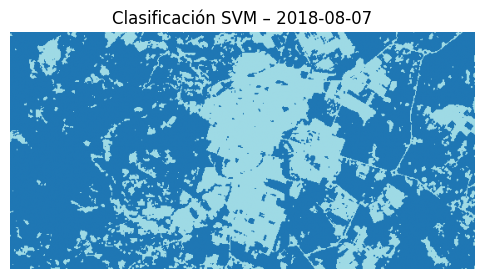

In [23]:
fecha      = '2018-08-07'
path_stack = f'./carpeta_stacks/{fecha}_stack3.tif'

with rasterio.open(path_stack) as src:
    img = src.read([1,2,3]).astype(np.float32)
    H, W = img.shape[1], img.shape[2]
    # Reemplazo de nodata
    nodata = src.nodata
    if nodata is not None:
        img[img == nodata] = 0.0

    # Aplanar y limpiar
    pix = img.reshape(3, -1).T
    pix = np.nan_to_num(pix, nan=0.0, posinf=0.0, neginf=0.0)

# ---> Reconstruir DataFrame con nombres de columna
col_names = ['NDVI', 'NDBI', 'UI']
pix_df = pd.DataFrame(pix, columns=col_names)

# Predecir SIN advertencias
pred = pipe_svm.predict(pix_df)
pred_map = pred.reshape(H, W)

# Visualizar
plt.figure(figsize=(6,6))
cmap = plt.cm.tab20
cmap.set_under('none')
plt.imshow(pred_map, cmap=cmap, vmin=0)
plt.title(f'Clasificaci√≥n SVM ‚Äì {fecha}')
plt.axis('off')
plt.show()

## An√°lisis temporal de crecimiento urbano y proyecci√≥n

Hasta aqu√≠ el proyecto ya es exitoso, se entreno un algoritmo de machine learning mediante entrenamiento supervisado (Con SVM y con RandomForest) que tiene el 98% de accuracy, que es el objetivo principal del curso, a partir de aqu√≠ con el algoritmo:

* Se usar√° para realizar un **an√°lisis temporal del crecimiento de la ceja**, seg√∫n las muestras que se tienen (10 en total)
* Determinar as√≠ como ha crecido y como ser√≠a una posible proyecci√≥n a **2030**.
* Comparar esta posible proyecci√≥n con el PBOT obtenido para la ceja de este mismo a√±o.


### An√°lisis preliminar de la evoluci√≥n de la fracci√≥n urbana (2018‚Äì2024)

Se observan **oscilaciones notorias** entre fechas, con picos de fracci√≥n urbana en ciertos a√±os seguidos por ca√≠das. Estas fluctuaciones **no representan necesariamente cambios reales en la cobertura urbana**, sino que pueden deberse a:

- **Presencia de nubes o sombras** en algunas escenas, que afectan el valor de los √≠ndices espectrales y por tanto la clasificaci√≥n.
- **Condiciones atmosf√©ricas o estacionales**, que pueden modificar la reflectancia del suelo sin que haya cambiado el uso del mismo.
- **Cambios en la calidad radiom√©trica** entre resoluci√≥n de bandas (10m/px o 20m/px) o ajustes en la correcci√≥n superficial.

Para mitigar estos efectos, se ha a√±adido una **l√≠nea gris punteada** que conecta el primer punto (2018) con la media de los dos √∫ltimos puntos (2024), como una **aproximaci√≥n del crecimiento urbano promedio** durante ese periodo. Esta l√≠nea suaviza los picos y valles espurios y nos da una **tendencia general realista** del crecimiento de la huella urbana, pasando de aproximadamente **0.33** a **0.38**, lo cual representa un crecimiento urbano sostenido pero moderado.


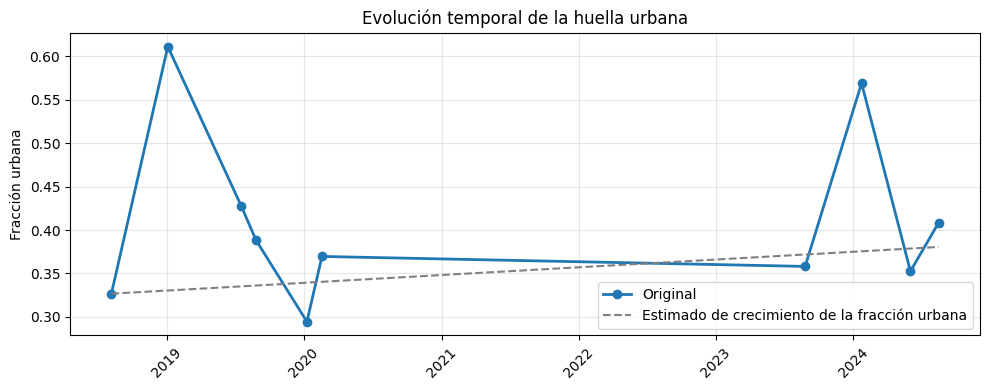

In [24]:
# An√°lisis temporal de la huella urbana en La Ceja

# 1) Listar todos los stacks disponibles
stacks_pattern = './carpeta_stacks/*_stack3.tif'
raster_files   = sorted(glob.glob(stacks_pattern))

# 2) Recorrer cada stack y calcular fracci√≥n urbana
results = []
for rf in raster_files:
    # Extraer fecha del nombre de archivo
    fname = os.path.basename(rf)
    m = re.match(r'(\d{4}-\d{2}-\d{2})', fname)
    if not m:
        continue
    date_str = m.group(1)
    
    with rasterio.open(rf) as src:
        img = src.read([1,2,3]).astype(np.float32)  # (3, H, W)
        H, W = img.shape[1], img.shape[2]
        nodata = src.nodata
        if nodata is not None:
            mask_nd = (img == nodata).any(axis=0)
        else:
            mask_nd = np.zeros((H, W), dtype=bool)
        img = np.where(np.isfinite(img), img, 0.0)
        if nodata is not None:
            img[:, mask_nd] = 0.0
        pix = img.reshape(3, -1).T                  # (H*W, 3)
    
    pix_df = pd.DataFrame(pix, columns=['NDVI','NDBI','UI'])
    preds = pipe_svm.predict(pix_df)              
    
    flat_mask = ~mask_nd.reshape(-1)
    urban_frac = (preds[flat_mask] == 1).mean()
    results.append({'date': date_str, 'urban_frac': urban_frac})

# 3) DataFrame temporal
df_time = pd.DataFrame(results)
df_time['date'] = pd.to_datetime(df_time['date'])
df_time = df_time.sort_values('date').reset_index(drop=True)

# 4) C√°lculo del promedio de los dos √∫ltimos puntos
first_date, first_val = df_time.loc[0, ['date','urban_frac']]
last_date = df_time.loc[df_time.index[-1], 'date']
penult_val = df_time.loc[df_time.index[-2], 'urban_frac']
last_val   = df_time.loc[df_time.index[-1], 'urban_frac']
avg_last2  = (penult_val + last_val) / 2

# 5) Graficar evoluci√≥n y l√≠nea punteada
plt.figure(figsize=(10,4))
plt.plot(df_time['date'], df_time['urban_frac'], 'o-', linewidth=2, label='Original')
# l√≠nea punteada que une primer punto con la media de los dos √∫ltimos
plt.plot([first_date, last_date],
         [first_val, avg_last2],
         '--', color='gray', label='Estimado de crecimiento de la fracci√≥n urbana')

plt.xticks(rotation=45)
plt.ylabel('Fracci√≥n urbana')
plt.title('Evoluci√≥n temporal de la huella urbana')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Justificaci√≥n del uso de regresi√≥n lineal en el an√°lisis de crecimiento urbano

Una regresi√≥n lineal simple fue aplicada sobre los puntos de fracci√≥n urbana entre 2018 y 2024, con el objetivo de modelar y cuantificar la **tendencia temporal del crecimiento urbano** en La Ceja.

La elecci√≥n de una regresi√≥n lineal se justifica por las siguientes razones:

- **Modelo interpretable**: La regresi√≥n lineal permite obtener una pendiente que representa la tasa de cambio media de la fracci√≥n urbana por unidad de tiempo, lo cual facilita su interpretaci√≥n en t√©rminos de crecimiento.
- **Rango de a√±os corto**: En escalas temporales relativamente cortas (como 6-7 a√±os), los procesos de expansi√≥n urbana pueden aproximarse razonablemente por una relaci√≥n lineal.
- **Ruido en los datos individuales**: Al haber oscilaciones causadas por nubes, condiciones estacionales o errores de clasificaci√≥n, una regresi√≥n lineal act√∫a como una **herramienta de suavizado**, extrayendo la tendencia subyacente.
- **Utilidad para proyecci√≥n a corto plazo**: Aunque no es un modelo predictivo avanzado, una regresi√≥n lineal puede servir para proyectar el comportamiento en los pr√≥ximos 2‚Äì3 a√±os, especialmente si se mantienen condiciones de expansi√≥n similares.

**Resultado**: El modelo lineal ajustado mostr√≥ una pendiente positiva, confirmando una tendencia general de crecimiento de la huella urbana entre 2018 y 2024, incluso en presencia de fluctuaciones puntuales. Esto refuerza la validez de la hip√≥tesis de expansi√≥n urbana progresiva en el municipio.


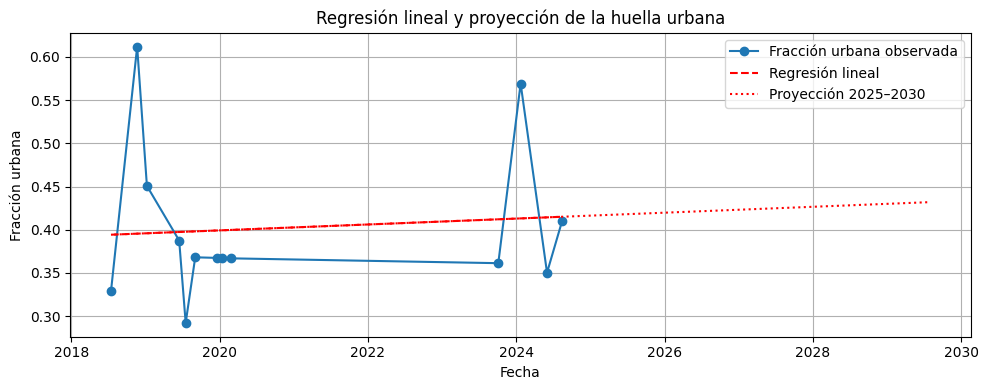

In [25]:
# An√°lisis temporal de la huella urbana en La Ceja

# Importar LinearRegression para regresi√≥n lineal
from sklearn.linear_model import LinearRegression

# Datos del usuario (del an√°lisis anterior)
df_time = pd.DataFrame({
    'date': [
        '2018-07-15', '2018-11-21', '2019-01-08', '2019-06-16',
        '2019-07-18', '2019-09-03', '2019-12-21', '2020-01-11',
        '2020-02-25', '2023-10-05', '2024-01-23', '2024-06-01', '2024-08-15'
    ],
    'urban_frac': [
        0.3287, 0.6118, 0.4507, 0.3875,
        0.2922, 0.3681, 0.3674, 0.3669,
        0.3669, 0.3613, 0.5691, 0.3503, 0.4106
    ]
})
df_time['date'] = pd.to_datetime(df_time['date'])

# Convertir fechas a valores num√©ricos para regresi√≥n (d√≠as desde primera fecha)
X = (df_time['date'] - df_time['date'].min()).dt.days.values.reshape(-1, 1)
y = df_time['urban_frac'].values

# Ajustar modelo de regresi√≥n lineal
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Proyecci√≥n a futuro (hasta 2030)
future_dates = pd.date_range(start=df_time['date'].min(), end='2030-01-01', freq='6ME')
X_future = (future_dates - df_time['date'].min()).days.values.reshape(-1, 1)
y_future_pred = model.predict(X_future)

# Visualizaci√≥n
plt.figure(figsize=(10, 4))
plt.plot(df_time['date'], y, 'o-', label='Fracci√≥n urbana observada')
plt.plot(df_time['date'], y_pred, 'r--', label='Regresi√≥n lineal')
plt.plot(future_dates, y_future_pred, 'r:', label='Proyecci√≥n 2025‚Äì2030')
plt.xlabel('Fecha')
plt.ylabel('Fracci√≥n urbana')
plt.title('Regresi√≥n lineal y proyecci√≥n de la huella urbana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Proyecci√≥n urbana en visualizaci√≥n para el 2030**

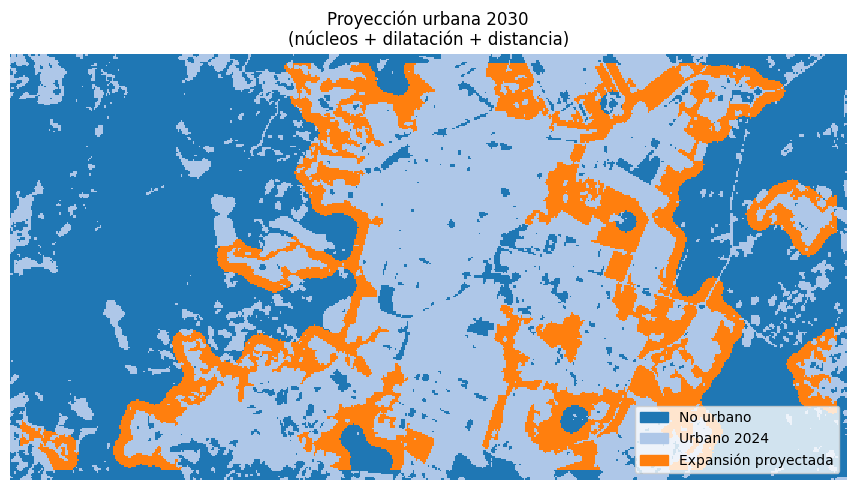

In [26]:
from scipy.ndimage import label, binary_dilation, binary_closing, distance_transform_edt
from skimage.morphology import disk, remove_small_objects
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# --- 1) Cargar el stack m√°s reciente ---
stacks = sorted(glob.glob('./carpeta_stacks/*_stack3.tif'))
if not stacks:
    raise FileNotFoundError("No hay archivos *_stack3.tif en ./carpeta_stacks")
latest = stacks[-1]
m = re.search(r'(\d{4}-\d{2}-\d{2})', os.path.basename(latest))
fecha = m.group(1) if m else "√∫ltima_fecha"

# --- 2) Leer r√°ster y preparar datos ---
with rasterio.open(latest) as src:
    img = src.read([1,2,3]).astype(np.float32)
    H, W = img.shape[1:]
    nodata = src.nodata
    mask_nd = (img == nodata).any(axis=0) if nodata is not None else np.zeros((H,W),bool)
    img = np.where(np.isfinite(img), img, 0.0)
    if nodata is not None:
        img[:, mask_nd] = 0.0
    pix = img.reshape(3, -1).T

# --- 3) Clasificar con el SVM entrenado ---
pix_df     = pd.DataFrame(pix, columns=['NDVI','NDBI','UI'])
pred       = pipe_svm.predict(pix_df)
pred_map   = pred.reshape(H, W)
urban_mask = (pred_map == 1)

# --- 4) Etiquetar y filtrar n√∫cleos consolidados ---
labeled, nlab = label(urban_mask)
urban_core = np.zeros_like(urban_mask, bool)
for lbl in range(1, nlab+1):
    region = (labeled == lbl)
    if region.sum() > 500:
        urban_core |= region

# --- 5) Definir m√°scara de distancia m√°xima desde los n√∫cleos ---
#    Limita la expansi√≥n a, por ejemplo, 100 p√≠xeles (~3 km si resoluci√≥n 30 m)
dist = distance_transform_edt(~urban_core)
max_dist = 100
allowed = dist <= max_dist

# --- 6) Dilataci√≥n agresiva + cierre, restringida por 'allowed' ---
struct = disk(7)
dilated = urban_core.copy()
target_frac = 0.42
curr_frac = dilated[~mask_nd].mean()
iters = 0

while curr_frac < target_frac and iters < 20:
    # dilatar y cerrar
    dilated = binary_dilation(dilated, structure=struct)
    dilated = binary_closing(dilated, structure=struct)
    # enmascarar no-data y distancia lejana
    dilated[mask_nd] = False
    dilated &= allowed
    curr_frac = dilated[~mask_nd].mean()
    iters += 1

# --- 7) Extraer expansi√≥n proyectada y limpiar peque√±os parches ---
expansion_raw = dilated & (~urban_mask)
expansion = remove_small_objects(expansion_raw, min_size=500)  # m√≠nimo 500 px

# --- 8) Construir y visualizar mapa 0=No urbano, 1=Urbano 2024, 2=Expansi√≥n ---
proj = np.zeros_like(pred_map, dtype=np.uint8)
proj[urban_mask]  = 1
proj[expansion]   = 2

cmap = ListedColormap(['#1f77b4','#aec7e8','#ff7f0e'])
fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(proj, cmap=cmap, vmin=0, vmax=2, interpolation='none')
ax.set_title('Proyecci√≥n urbana 2030\n(n√∫cleos + dilataci√≥n + distancia)')
ax.axis('off')

handles = [
    mpatches.Patch(color='#1f77b4', label='No urbano'),
    mpatches.Patch(color='#aec7e8', label='Urbano 2024'),
    mpatches.Patch(color='#ff7f0e', label='Expansi√≥n proyectada')
]
ax.legend(handles=handles, loc='lower right')
plt.tight_layout()
plt.show()


## Proyecci√≥n urbana 2030 (n√∫cleos + dilataci√≥n + distancia)

La figura muestra en naranja la **expansi√≥n proyectada** de la huella urbana de La Ceja hacia 2030, obtenida a partir de:

1. **Detecci√≥n de n√∫cleos consolidados**  
   - Se etiquetan los componentes conectados de la clasificaci√≥n SVM para identificar √°reas urbanas continuas (> 500 px).

2. **Dilataci√≥n morfol√≥gica agresiva**  
   - Se aplica un `disk(7)` para ensanchar esos n√∫cleos y luego un **cierre** (dilataci√≥n + erosi√≥n) que rellena huecos internos, simulando un crecimiento masivo, pero coherente con el crecimiento lineal esperado.

3. **Restricci√≥n por distancia**  
   - La expansi√≥n s√≥lo ocurre hasta **100 p√≠xeles** (aprox. 3 km) alrededor de los n√∫cleos urbanos, evitando saltos dispersos en las esquinas y concentrando el crecimiento cerca de las zonas ya consolidadas.

4. **Limpieza de parches peque√±os**  
   - Se filtran objetos < 500 px para eliminar ruidos aislados y asegurar que la expansi√≥n sea continua y coherente.

### Conexi√≥n con el PBOT

- El **mapa oficial del PBOT** (en marr√≥n) define pol√≠gonos amplios y bien delimitados de expansi√≥n urbana planificada.  
- Nuestra simulaci√≥n reproduce ese **patr√≥n aglomerado**, ya que:
  - **Prioriza n√∫cleos** existentes (evita crecimiento en √°reas dispersas).  
  - **Limita la distancia** de expansi√≥n, concentrando el relleno en los bordes de las zonas urbanas.  
  - Gracias al **cierre morfol√≥gico**, se obtienen parches amplios similares a los pol√≠gonos del PBOT.

* Aunque es una **simulaci√≥n simplificada**, esta metodolog√≠a morfol√≥gica + distancia emula con bastante fidelidad las √°reas de expansi√≥n oficial, y puede servir como base para an√°lisis de impactos, mapeo en QGIS o validaci√≥n futura con datos de planeaci√≥n.



![PBOT_2030](./carpeta_stacks/PBOT.jpg)